In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime
import matplotlib.dates as mdates

from datetime import timedelta, date
import time
import os

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

from jax import random
import numpyro
import numpyro.distributions as dist
import numpy.lib.stride_tricks as st

import scenario_generator.mcmc_forecast as mcmc
import scenario_generator.utils as u
import mechafil.data as mecha_data

In [3]:
# setup data access
mecha_data.setup_spacescope('/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json')

NDEVICES = 2 
numpyro.set_host_device_count(NDEVICES)

In [4]:
train_end_date = date.today()
train_start_date = train_end_date - timedelta(days=180)

forecast_length = 365
num_warmup_mcmc = 500
num_samples_mcmc = 500
seasonality_mcmc = 1000
num_chains_mcmc = 2
forecast_rb_date_vec, rb_onboard_power_pred, _, _ = \
    mcmc.forecast_rb_onboard_power(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend     -0.01      0.03     -0.01     -0.07      0.03    774.58      1.00
       init_s[0]     -2.31     32.31     -0.26    -25.67     15.42    259.18      1.00
       init_s[1]     -0.25      1.54     -0.64     -1.54      1.09     37.80      1.03
       init_s[2]     -0.72      1.17     -0.98     -2.17      0.79     93.96      1.01
       init_s[3]      0.52      1.14      0.34     -1.14      2.09    101.98      1.02
       init_s[4]      0.41      1.13      0.26     -1.27      2.05     66.99      1.04
       init_s[5]     -0.04      0.99     -0.13     -1.68      1.46     57.25      1.05
       init_s[6]      0.03      1.10     -0.08     -1.55      1.49    159.49      1.01
       init_s[7]     -0.71      0.85     -0.74     -1.97      0.81    180.65      1.01
       init_s[8]      0.03      0.79      0.01     -1.37      1.21    224.20      1.01
       init_s[9]      0.04      0.76      

In [5]:
# for plotting only
historical_x, historical_rbp = u.get_historical_daily_onboarded_power(train_start_date, train_end_date)

Text(0.5, 1.0, 'RB Onboarding Forecast')

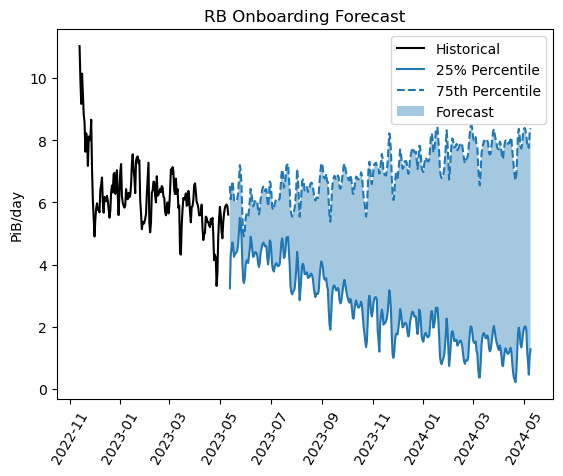

In [7]:
q_25 = np.quantile(rb_onboard_power_pred, 0.25, axis=0)
q_75 = np.quantile(rb_onboard_power_pred, 0.75, axis=0)

# make it less spikey
window_size=3
q_25_smooth = st.sliding_window_view(q_25, window_size).mean(axis=-1)
q_75_smooth = st.sliding_window_view(q_75, window_size).mean(axis=-1)
x_forecast = forecast_rb_date_vec[0:len(q_25_smooth)]

plt.figure()
plt.plot(historical_x, historical_rbp, label='Historical', color='k')
p = plt.plot(x_forecast, q_25_smooth, label='25% Percentile')
plt.plot(x_forecast, q_75_smooth, color=p[0].get_color(), label='75th Percentile', linestyle='--')
plt.fill_between(x_forecast, 
                 q_25_smooth, q_75_smooth, 
                 alpha=0.4, label='Forecast')
plt.xticks(rotation=60)
plt.legend()
plt.ylabel('PiB/day')
plt.title('RB Onboarding Forecast')

In [8]:
# print out rb onboarding for 25th and 75th quantiles for future date
onboarding_forecast_date = date(2024,1,1)
ix = np.where(np.asarray(forecast_rb_date_vec)==onboarding_forecast_date)[0][0]
print('Forecasted 25th Percentile onboarding rate @ %s = %0.02f' % (onboarding_forecast_date, q_25[ix]))
print('Forecasted 75th Percentile onboarding rate @ %s = %0.02f' % (onboarding_forecast_date, q_75[ix]))

Forecasted 25th Percentile onboarding rate @ 2024-01-01 = 1.52
Forecasted 75th Percentile onboarding rate @ 2024-01-01 = 6.92
